# Analisi minimi, massimi, media e deviazione standard

In [1]:
import pandas as pd
import os

In [2]:
dataset_path = os.path.join("Dataset", "dataset_dummy.csv")
df = pd.read_csv(dataset_path)

In [3]:
display(df)

,Time,Timestamp,DayOfWeek,Year,Month,Day,Hour,Minute,Second,P_CabinePower_L1,...,P L2 WS FM,P_CabineLight_L3,P L3 WS Emergency Light,P L3 WS Light,P L3 WS FanCoil,P L3 WS FM,PowerL1,PowerL2,PowerL3,TotalPower
0,2020-01-01 00:00:11,1.577833e+09,2,2020,1,1,0,0,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 00:00:26,1.577833e+09,2,2020,1,1,0,0,26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:00:41,1.577833e+09,2,2020,1,1,0,0,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 00:00:56,1.577833e+09,2,2020,1,1,0,0,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 00:01:11,1.577833e+09,2,2020,1,1,0,1,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6312955,2022-12-31 23:58:56,1.672528e+09,5,2022,12,31,23,58,56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6312956,2022-12-31 23:59:11,1.672528e+09,5,2022,12,31,23,59,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6312957,2022-12-31 23:59:26,1.672528e+09,5,2022,12,31,23,59,26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6312958,2022-12-31 23:59:41,1.672528e+09,5,2022,12,31,23,59,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
single_phase = ["P_CabinePower_L1", "P_HeatPump", "P_CabineLight_L3"]
three_phase = ["P WS Emergency Light", "P WS Light", "P WS FanCoil", "P WS FM"]

fields_sum = ["PowerL1", "PowerL2", "PowerL3", "TotalPower"]

L1 = ["P_CabinePower_L1", "P L1 WS Emergency Light", "P L1 WS Light", "P L1 WS FanCoil", "P L1 WS FM"]
L2 = ["P_HeatPump", "P L2 WS Emergency Light", "P L2 WS Light", "P L2 WS FanCoil", "P L2 WS FM"]
L3 = ["P_CabineLight_L3", "P L3 WS Emergency Light", "P L3 WS Light", "P L3 WS FanCoil", "P L3 WS FM"]

In [5]:
rounded_describe = df.describe().round(decimals=2)

In [6]:
rounded_describe[fields_sum]

,PowerL1,PowerL2,PowerL3,TotalPower
count,4383360.00,4383360.00,4383360.00,4383360.00
mean,1570.13,1723.49,1214.73,4508.36
std,804.35,511.58,491.98,1528.65
min,177.78,467.45,250.00,1646.14
25%,1052.99,1366.24,916.36,3506.73
50%,1295.00,1636.31,1070.00,4047.36
75%,1813.41,1999.83,1390.00,5063.92
max,5983.83,4250.86,3229.76,12895.54


In [7]:
rounded_describe[L1]

,P_CabinePower_L1,P L1 WS Emergency Light,P L1 WS Light,P L1 WS FanCoil,P L1 WS FM
count,4383360.00,4297503.00,4381894.00,4383360.00,4383360.00
mean,84.68,274.95,551.08,14.25,650.74
std,7.75,19.05,294.81,33.09,608.47
min,68.05,200.00,150.00,0.00,0.00
25%,81.83,260.00,350.00,0.00,320.00
50%,82.92,270.00,460.00,0.00,430.00
75%,84.12,280.00,690.00,0.00,680.00
max,149.98,350.00,1500.00,170.00,4000.00


In [8]:
rounded_describe[L2]

,P_HeatPump,P L2 WS Emergency Light,P L2 WS Light,P L2 WS FanCoil,P L2 WS FM
count,4383324.00,4246970.00,4383360.00,4383360.00,4322540.00
mean,233.85,296.93,714.29,0.00,494.53
std,231.45,37.18,295.14,0.01,216.12
min,0.00,200.00,230.00,0.00,0.00
25%,8.38,256.39,540.00,0.00,400.00
50%,199.33,290.00,650.00,0.00,460.00
75%,413.20,340.00,850.00,0.00,560.00
max,999.99,400.00,1700.00,10.00,1300.00


In [9]:
rounded_describe[L3]

,P_CabineLight_L3,P L3 WS Emergency Light,P L3 WS Light,P L3 WS FanCoil,P L3 WS FM
count,4383360.00,3114374.00,4228386.00,4383360.00,4357649.00
mean,2.93,306.66,372.61,27.05,611.01
std,2.77,24.31,119.93,46.06,426.59
min,0.00,250.00,200.00,0.00,200.00
25%,0.00,300.00,270.00,0.00,300.00
50%,4.55,320.00,350.00,0.00,460.00
75%,5.53,320.00,430.00,70.00,740.00
max,10.00,350.00,1000.00,200.00,2000.00


# BoxPlot

In [10]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from scipy.signal import resample

In [11]:
color1 = "#c8a2c8" # lilla
color2 = "#6495ed" # blu fiordaliso
color3 = "#93ccea" # blu fiordaliso chiaro
color4 = "#000000" # nero
color5 = "#2271b3" # blu cielo
palette = ["#FED4CB", "#FFF2CC", "#C8E1FF", "#D5EDF7", "#F5D0C5", "#E2D7FF", "#FAD6A5"]

In [12]:
plot_path = os.path.join("Plot", "PlotDataset")
plot_path = os.path.join(plot_path, "BoxPlot")
dataset_path = os.path.join("Dataset", "dataset_dummy.csv")

In [13]:
counter = 0
def make_path(base_path, file_name):
    global counter
    counter += 1
    file_name = str(counter) + "-" + file_name  
    return os.path.join(base_path, file_name)

In [14]:
df = pd.read_csv(dataset_path)

In [15]:
fields = [
    "P_CabinePower_L1", "P L1 WS Emergency Light", "P L1 WS Light", "P L1 WS FanCoil", "P L1 WS FM",
    "P_HeatPump", "P L2 WS Emergency Light", "P L2 WS Light", "P L2 WS FanCoil", "P L2 WS FM",
    "P_CabineLight_L3", "P L3 WS Emergency Light", "P L3 WS Light", "P L3 WS FanCoil", "P L3 WS FM"
]

In [16]:
def plot_boxplot(data, start, end, fields, colors, title, ylabel, dim, plot_path):
    
    df_tmp = data[
        (data["Year"] >= start.year) & (data["Year"] <= end.year) &
        (data["Month"] >= start.month) & (data["Month"] <= end.month) &
        (data["Day"] >= start.day) & (data["Day"] <= end.day) &
        (data["Hour"] >= start.hour) & (data["Hour"] <= end.hour) &
        (data["Minute"] >= start.minute) & (data["Minute"] <= end.minute) &
        (data["Second"] >= start.second) & (data["Second"] <= end.second)
    ]
    
    plt.figure(figsize=dim) 
    #plt.yscale("log")
    
    plt.title(title)
    plt.ylabel(ylabel)
    
    data_for_plot = [df_tmp[item] for item in fields]
    sns.boxplot(data=data_for_plot)#, palette=colors)
    
    plt.xticks(list(range(0,len(fields))), fields)

    file_name = "".join(title.lower()).replace(" ", "_")
    path = make_path(plot_path, file_name)
    plt.savefig(path, bbox_inches='tight', transparent=True)
    
    plt.show()

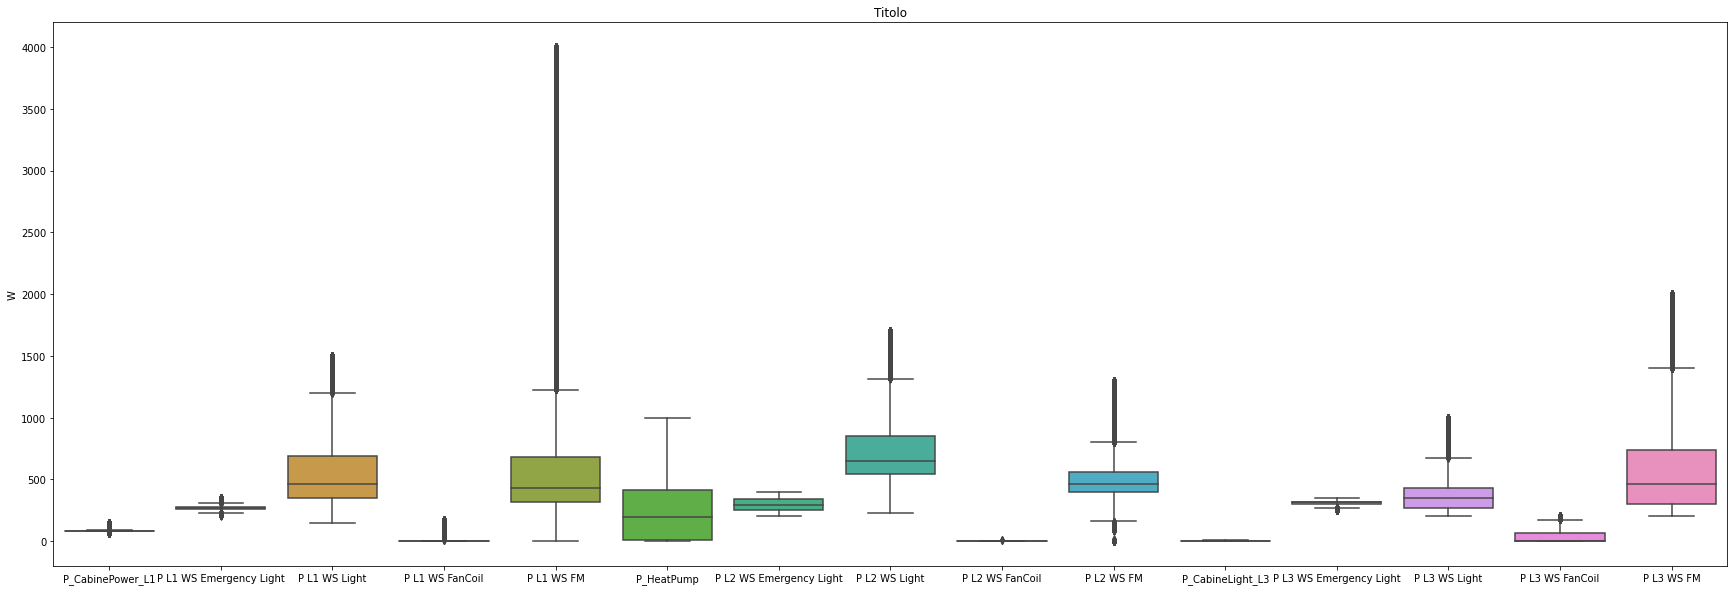

In [17]:
start = datetime(2020, 1, 1, 0, 0, 0)
end = datetime(2022, 12, 31, 23, 59, 59)
title = "Titolo"
ylabel = "W"
dim = (30,10)
plot_boxplot(df, start, end, fields, palette, title, ylabel, dim, plot_path)

In [18]:
df_weekday = df[(df["DayOfWeek"] >= 0) & (df["DayOfWeek"] <= 4)]
df_weekend = df[(df["DayOfWeek"] >= 5) & (df["DayOfWeek"] <= 6)]

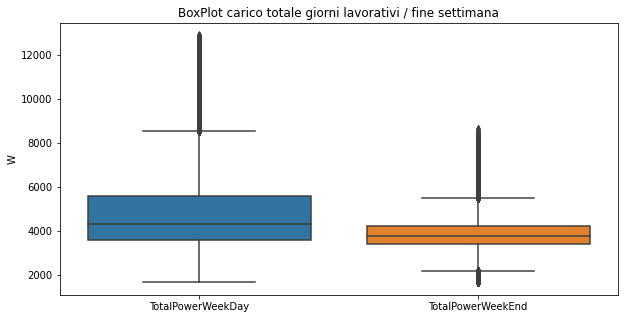

In [19]:
title = "BoxPlot carico totale giorni lavorativi / fine settimana"
ylabel = "W"
dim = (10,5)

plt.figure(figsize=dim) 

plt.title(title)
plt.ylabel(ylabel)

data_for_plot = [df_weekday["TotalPower"], df_weekend["TotalPower"]]
sns.boxplot(data=data_for_plot)

plt.xticks([0,1], ["TotalPowerWeekDay", "TotalPowerWeekEnd"])

#file_name = "".join(title.lower()).replace(" ", "_")
#path = make_path(plot_path, file_name)
#plt.savefig(path, bbox_inches='tight', transparent=True)

plt.show()

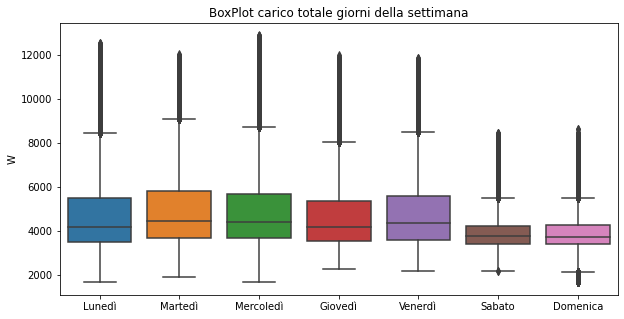

In [20]:
title = "BoxPlot carico totale giorni della settimana"
ylabel = "W"
dim = (10,5)

plt.figure(figsize=dim) 

plt.title(title)
plt.ylabel(ylabel)

data_for_plot = [df[df["DayOfWeek"] == i]["TotalPower"] for i in range(0,7)]
sns.boxplot(data=data_for_plot)

plt.xticks([0,1,2,3,4,5,6], ["Lunedì", "Martedì", "Mercoledì", "Giovedì", "Venerdì", "Sabato", "Domenica"])

#file_name = "".join(title.lower()).replace(" ", "_")
#path = make_path(plot_path, file_name)
#plt.savefig(path, bbox_inches='tight', transparent=True)

plt.show()

# Istogrammi (occorrenze valori)

In [ ]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import collections

In [ ]:
color1 = "#c8a2c8" # lilla
color2 = "#6495ed" # blu fiordaliso
color3 = "#93ccea" # blu fiordaliso chiaro
color4 = "#000000" # nero
color5 = "#2271b3" # blu cielo
palette = ["#FED4CB", "#FFF2CC", "#C8E1FF", "#D5EDF7", "#F5D0C5", "#E2D7FF", "#FAD6A5"]

In [ ]:
plot_path = os.path.join("Plot", "IstogrammiDistribuzione")
dataset_path = os.path.join("Dataset", "dataset_dummy.csv")

In [ ]:
counter = 0
def make_path(base_path, file_name):
    global counter
    counter += 1
    file_name = str(counter) + "-" + file_name  
    return os.path.join(base_path, file_name)

In [ ]:
df = pd.read_csv(dataset_path)

In [ ]:
def plot_distribution(data, start, end, field, title, xlabel, ylabel, dim, c1, c2, plot_path):
    
    df_tmp = data[
        (data["Year"] >= start.year) & (data["Year"] <= end.year) &
        (data["Month"] >= start.month) & (data["Month"] <= end.month) &
        (data["Day"] >= start.day) & (data["Day"] <= end.day) &
        (data["Hour"] >= start.hour) & (data["Hour"] <= end.hour) &
        (data["Minute"] >= start.minute) & (data["Minute"] <= end.minute) &
        (data["Second"] >= start.second) & (data["Second"] <= end.second) &
        (data[field] >= 0) & (data[field] <= 10000)
    ]
    
    plt.figure(figsize=dim)
    plt.grid(color=c2, linestyle='-', linewidth=0.2, axis="y")

    file_name = "".join(title.lower()).replace(" ", "_")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.yscale("log")
    
    value_counts = df_tmp[field].value_counts().sort_index()
    x = value_counts.index
    y = value_counts.values

    plt.plot(x, y, color=c1, linewidth="3")
    
    min_x, max_x = np.min(x), np.max(x)
    num_ticks = 20
    x_ticks = np.linspace(min_x, max_x, num_ticks)
    plt.xticks(x_ticks, rotation=45)

    #plt.savefig(make_path(plot_path, file_name), bbox_inches='tight', transparent=True)
    plt.show()

### Plot singolo

In [ ]:
start = datetime(2020, 1, 1, 0, 0, 0)
end = datetime(2022, 12, 31, 23, 59, 59)
field = "TotalPower"
plot_distribution(df, start, end, field, "title", "xlabel", "ylabel", (15,5), color1, color4, plot_path)

### Plot multiplo

In [ ]:
list_of_field = [
    "P_HeatPump", "P_CabinePower_L1", "P_CabineLight_L3", 
    "P WS Emergency Light", "P WS Light", "P WS FanCoil", "P WS FM"       
]

In [ ]:
start = datetime(2021, 1, 1, 0, 0, 0)
end = datetime(2022, 12, 31, 23, 59, 59)
for field in list_of_field:
    d = get_distribution_dict(df, start, end, field)
    plot_distribution(d, "Distribuzione", field, "#occorrenze", (15,5), color1, color4, plot_path)